In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa

from glob import glob
from tqdm import tqdm

from imgaug import augmenters as iaa
import imgaug as ia

import argparse
import wandb
from wandb.keras import WandbCallback
wandb.init(project="DACON_235894", name="EfficientNetB0")

parser = argparse.ArgumentParser(description='EfficientNetB0')
parser.add_argument('--resize_size', default=256, type=int)
parser.add_argument('--geometric_transform', default="simple", type=str) # simple or advanced
parser.add_argument('--randaugment', default=True, type=bool)
parser.add_argument('--randaugment_n', default=4, type=int)
parser.add_argument('--randaugment_m', default=8, type=int)
parser.add_argument('--optimizer', default="adamw", type=str) # adam or adamw
parser.add_argument('--loss', default="cc", type=str) # cc or fl
parser.add_argument('--label_smoothing', default=0, type=float) # cc or fl
parser.add_argument('--class_weight', default=False, type=bool) # False or True
parser.add_argument('--batch_size', default=64, type=int)
parser.add_argument('--epochs', default=100, type=int)
parser.add_argument('--validation_split', default=0.15, type=float)
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

wandb.config.update(args)

resize_size=args.resize_size
BATCH_SIZE=args.batch_size
EPOCHS=args.epochs
VALIDATION_SPLIT=args.validation_split
SEED=args.seed

if args.optimizer == "adam":
    optim = tf.keras.optimizers.Adam(learning_rate=0.001)
elif args.optimizer == "adamw":
    optim = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

if args.loss == "cc":
    loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=args.label_smoothing)
elif args.loss == "fl":
    loss_function = tfa.losses.SigmoidFocalCrossEntropy()

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    ia.seed(seed)

set_seeds()

wandb: Currently logged in as: gnoeyheat (use `wandb login --relogin` to force relogin)


## Preprocessing

In [2]:
%%time

import pickle
import gzip

with gzip.open(f'preprocess_data/train_imgs_256i.pkl','rb') as f:
    train_imgs = pickle.load(f)

with gzip.open(f'preprocess_data/test_imgs_256i.pkl','rb') as f:
    test_imgs = pickle.load(f)
    
train_imgs.shape, test_imgs.shape

CPU times: total: 23.5 s
Wall time: 23.5 s


((4277, 256, 256, 3), (2154, 256, 256, 3))

In [3]:
# train_imgs = train_imgs.astype("uint8")
# train_imgs.dtype

In [4]:
import abc
import itertools
import numpy as np

from keras.preprocessing.image import apply_affine_transform


class AffineTransformation(object):
    def __init__(self, flip, tx, ty, k_90_rotate):
        self.flip = flip
        self.tx = tx
        self.ty = ty
        self.k_90_rotate = k_90_rotate

    def __call__(self, x):
        res_x = x
        if self.flip:
            res_x = np.fliplr(res_x)
        if self.tx != 0 or self.ty != 0:
            res_x = apply_affine_transform(res_x, tx=self.tx, ty=self.ty, channel_axis=2, fill_mode='reflect')
        if self.k_90_rotate != 0:
            res_x = np.rot90(res_x, self.k_90_rotate)

        return res_x


class AbstractTransformer(abc.ABC):
    def __init__(self):
        self._transformation_list = None
        self._create_transformation_list()

    @property
    def n_transforms(self):
        return len(self._transformation_list)

    @abc.abstractmethod
    def _create_transformation_list(self):
        return

    def transform_batch(self, x_batch, t_inds):
        assert len(x_batch) == len(t_inds)

        transformed_batch = x_batch.copy()
        for i, t_ind in enumerate(t_inds):
            transformed_batch[i] = self._transformation_list[t_ind](transformed_batch[i])
        return transformed_batch


class Transformer(AbstractTransformer):
    def __init__(self, translation_x=8, translation_y=8):
        self.max_tx = translation_x
        self.max_ty = translation_y
        super().__init__()

    def _create_transformation_list(self):
        transformation_list = []
        for is_flip, tx, ty, k_rotate in itertools.product((False, True),
                                                           (0, -self.max_tx, self.max_tx),
                                                           (0, -self.max_ty, self.max_ty),
                                                           range(4)):
            transformation = AffineTransformation(is_flip, tx, ty, k_rotate)
            transformation_list.append(transformation)

        self._transformation_list = transformation_list


class SimpleTransformer(AbstractTransformer):
    def _create_transformation_list(self):
        transformation_list = []
        for is_flip, k_rotate in itertools.product((False, True),
                                                    range(4)):
            transformation = AffineTransformation(is_flip, 0, 0, k_rotate)
            transformation_list.append(transformation)

        self._transformation_list = transformation_list

In [5]:
%%time

train_y = pd.read_csv("raw_data/train_df.csv")

train_labels = train_y["label"]
label_unique = sorted(np.unique(train_labels))
label_unique = {key : value for key, value in zip(label_unique, range(len(label_unique)))}

train_y_good = train_y[train_y["state"]=="good"]["label"]
train_y_bad = train_y[train_y["state"]!="good"]["label"]
train_imgs_good = train_imgs[train_y_good.index]
train_imgs_bad = train_imgs[train_y_bad.index]

if args.geometric_transform=="simple":
    transformer = SimpleTransformer()
elif args.geometric_transform=="advanced":
    transformer = Transformer()
    
transformations_inds = np.tile(np.arange(transformer.n_transforms), len(train_imgs_bad))
train_imgs_bad_transformed = transformer.transform_batch(np.repeat(train_imgs_bad, transformer.n_transforms, axis=0),
                                                         transformations_inds)
train_y_bad_transformed = np.repeat(train_y_bad, transformer.n_transforms)

X = np.concatenate((train_imgs_good, train_imgs_bad_transformed), axis=0)
y = np.concatenate((train_y_good, train_y_bad_transformed), axis=0)

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=VALIDATION_SPLIT, random_state=SEED, stratify=y)

y_train = [label_unique[k] for k in y_train]
y_train = np.array(y_train)

y_val = [label_unique[k] for k in y_val]
y_val = np.array(y_val)

y_train=tf.keras.utils.to_categorical(y_train)
y_val=tf.keras.utils.to_categorical(y_val)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(7491, 256, 256, 3) (1322, 256, 256, 3) (7491, 88) (1322, 88)
CPU times: total: 9.16 s
Wall time: 9.16 s


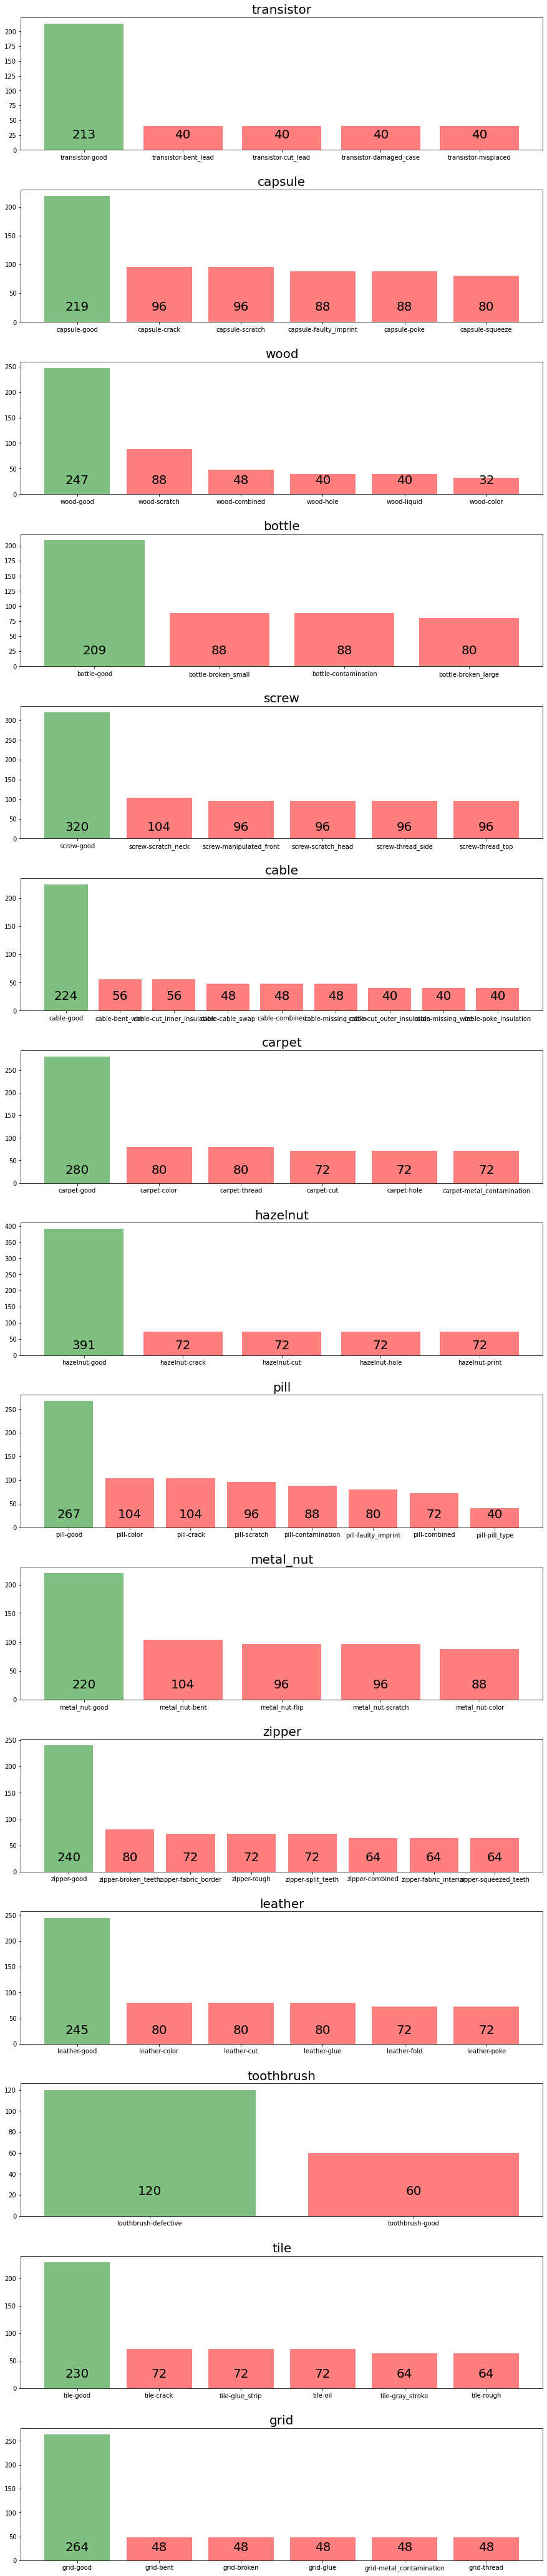

In [6]:
classList = train_y['class'].unique()

y_class = pd.concat([train_y[train_y["state"]=="good"]["class"],
                     np.repeat(train_y[train_y["state"]!="good"]["class"],
                               transformer.n_transforms)])

labelCount=pd.DataFrame({"class" : y_class, "label" : y}).groupby('label').count().rename(columns={'class': 'count'})

anomaly_dict = {}
for className in classList:
    df = pd.DataFrame(labelCount[labelCount.index.str.contains(className)]).sort_values(by='count', ascending=False)
    anomaly_dict[className] = df
    
fig, axs = plt.subplots(15, 1, figsize=(15, 15*5))
fig.subplots_adjust(hspace = .3)
axs = axs.ravel()

for i, (className, df) in enumerate(anomaly_dict.items()):
    colors = ['red' for i in range(len(df.index))]
    colors[0] = 'green'
    axs[i].bar(df.index, df.iloc[:, 0], color=colors, alpha=0.5)
    axs[i].set_title(className, fontsize=20)
    for j, value in enumerate(df.iloc[:, 0]):
        axs[i].text(j, 20, df.iloc[:, 0][j], ha='center', fontsize=20)

In [7]:
rand_aug = iaa.RandAugment(n=args.randaugment_n, m=args.randaugment_m, seed=SEED)

def augment(images):
    if args.randaugment==True:
        images = tf.cast(images, tf.uint8)
        images = rand_aug(images=images.numpy())
    return images

train_ds_rand = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(len(X_train))
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.py_function(augment, [x], [tf.float32])[0], y),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_imgs))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

## Modelling

In [8]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
layer_names = [
    "avg_pool"
]
layers = [base_model.get_layer(name).output for name in layer_names]
sampling_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

# sampling_model.trainable = False

model=tf.keras.Sequential([
    sampling_model,
    tf.keras.layers.Dense(y_train.shape[1], activation="softmax")
])

model.compile(
    optimizer=optim,
    loss=loss_function,
    metrics=tfa.metrics.F1Score(num_classes=y_train.shape[1], average="macro")
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1280)              4049571   
                                                                 
 dense (Dense)               (None, 88)                112728    
                                                                 
Total params: 4,162,299
Trainable params: 4,120,276
Non-trainable params: 42,023
_________________________________________________________________


In [9]:
checkpoint_path=f"load_model/{parser.description}"

callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )
]

if args.class_weight==True:
    class_weight = [label_unique[k] for k in y]
    class_weight = (1 / np.bincount(class_weight)) * (len(class_weight))
    class_weight = class_weight / class_weight.sum()
    class_weight = {key : value for key, value in zip(range(len(class_weight)), class_weight)}
else:
    class_weight = None
    
history=model.fit(
    train_ds_rand,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[callback, WandbCallback()],
    validation_data=val_ds,
    class_weight=class_weight
    )

Epoch 1/100
118/118 [==============================] - ETA: 0s - loss: 1.4532 - f1_score: 0.4291

C:\Users\Taehyeong\anaconda3\envs\DACON_tf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


118/118 [==============================] - 72s 471ms/step - loss: 1.4532 - f1_score: 0.4291 - val_loss: 0.9849 - val_f1_score: 0.5312 - _timestamp: 1649686172.0000 - _runtime: 131.0000
Epoch 2/100
118/118 [==============================] - 62s 508ms/step - loss: 0.6829 - f1_score: 0.7092 - val_loss: 0.5421 - val_f1_score: 0.7557 - _timestamp: 1649686238.0000 - _runtime: 197.0000
Epoch 3/100
118/118 [==============================] - 61s 497ms/step - loss: 0.4920 - f1_score: 0.8034 - val_loss: 0.2863 - val_f1_score: 0.8827 - _timestamp: 1649686302.0000 - _runtime: 261.0000
Epoch 4/100
118/118 [==============================] - 59s 480ms/step - loss: 0.4129 - f1_score: 0.8449 - val_loss: 0.3229 - val_f1_score: 0.8727 - _timestamp: 1649686365.0000 - _runtime: 324.0000
Epoch 5/100
118/118 [==============================] - 61s 496ms/step - loss: 0.3227 - f1_score: 0.8790 - val_loss: 0.2289 - val_f1_score: 0.9015 - _timestamp: 1649686428.0000 - _runtime: 387.0000
Epoch 6/100
118/118 [======

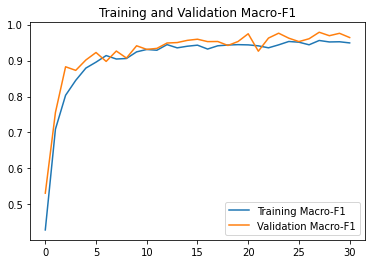

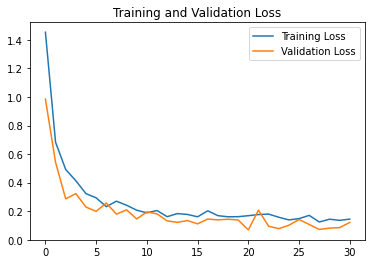

In [10]:
acc = history.history['f1_score']
val_acc = history.history['val_f1_score']

loss=history.history['loss']
val_loss=history.history['val_loss']

plt.plot(acc, label='Training Macro-F1')
plt.plot(val_acc, label='Validation Macro-F1')
plt.legend(loc='lower right')
plt.title('Training and Validation Macro-F1')
plt.show()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
model.load_weights(checkpoint_path)

## Inference

In [12]:
pred_prob = model.predict(test_ds)
f_pred = np.argmax(pred_prob, axis=1)
label_decoder = {val:key for key, val in label_unique.items()}
f_result = [label_decoder[result] for result in f_pred]

pd.Series(f_result).value_counts()

pill-good          106
transistor-good    101
hazelnut-good       95
cable-good          93
screw-good          85
                  ... 
grid-bent            4
hazelnut-crack       4
grid-thread          3
zipper-combined      3
wood-combined        2
Length: 87, dtype: int64

In [13]:
submission = pd.read_csv("raw_data/sample_submission.csv")
submission["label"] = f_result
submission.to_csv("submission.csv", index=False)